<a href="https://colab.research.google.com/github/janputra/Physic-Informed-Neural-Networks-Practices-/blob/main/PINN_Horn_ODE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pyDOE

Requirement already up-to-date: pyDOE in /usr/local/lib/python3.6/dist-packages (0.3.8)


In [ ]:
# import pathlib 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model
from pyDOE import lhs

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x = (1)*lhs(1, 2000)
x= np.append(x,[0,1])


In [ ]:
l0=125.7
X=tf.convert_to_tensor(x,tf.float32)
u0=-10/1000/l0
u0=np.array(u0).reshape(1,1)
u1=10/1000/l0
u1=np.array(u1).reshape(1,1)

x0=0
x0=np.array(x0).reshape(1,1)
x1=1
x1=np.array(x1).reshape(1,1)

print (u0)
print(u1)

[[-7.95544948e-05]]
[[7.95544948e-05]]


In [ ]:
def build_model(layers):
    i = Input(shape=(layers[0],))
    o = Dense(layers[1],activation="tanh")(i) 
    for x in layers[2:-1]:
        o = Dense(x,activation="tanh")(o)
    o = Dense(layers[-1],activation="linear")(o)
    model=Model(inputs=i, outputs=o)
    return model


In [ ]:
layers=[1,40,40,40,40,40,40,1]
model=build_model(layers)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 40)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640  

In [ ]:
  # The actual PINN
k = tf.Variable([0.1], dtype=tf.float32)


def _wrap_training_variables():
    var=model.trainable_variables
    var.extend([k])
    return var

def _loss():
    with tf.GradientTape(persistent=True) as tape:
       tape.watch(X)

       u=model(X)
       # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
       u_x = tape.gradient(u, X)
     
    u_xx = tape.gradient(u_x, X)

    # Letting the tape go
    del tape

    # Buidling the PINNs
    bc1= u_xx + ((k*l0)**2)*u  
 
    return tf.reduce_mean(tf.square(bc1)) + tf.square(model(x0)-u0) + tf.square(model(x1)-u1) + tf.square(u_x[-1])  +tf.square(u_x[-2])



def _grad():
    with tf.GradientTape() as tape:
          loss_value = _loss()
    return loss_value, tape.gradient(loss_value,_wrap_training_variables())

def fit():
    for epoch in range(epochs):
        # Optimization step
        loss_value, grads = _grad()
        optimizer.apply_gradients(zip(grads, _wrap_training_variables()))

    print ('epoch : ',epoch,' loss : ',loss_value )
    

def predict(x):
    return model(x)


In [ ]:
test=np.arange(0,125.7,0.1)
test=test/l0
optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.01)

In [ ]:
epochs = 100
fit()


x=model.predict(test)
plt.figure()
plt.plot(test,x, color='r')
plt.show()

KeyboardInterrupt: ignored

epoch :  9  loss :  tf.Tensor([[0.00088154]], shape=(1, 1), dtype=float32)


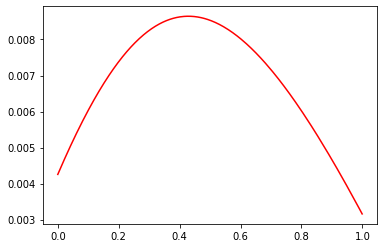

In [ ]:
epochs = 10
fit()


x=model.predict(test)
plt.figure()
plt.plot(test,x, color='r')
plt.show()

In [ ]:
x.shape


(1257, 1)

In [ ]:
x[1256]

array([0.00315841], dtype=float32)

In [ ]:
k

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.01727157], dtype=float32)>

In [ ]:
c=5028
omega=k*1000*c
freq=omega/(2*math.pi)
freq

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([13821.25], dtype=float32)>